# Modelos Estadísticos
* Se realiza un análisis de la predicción del precio de cierre de Bitcoin utilizando suavizado exponencial. Se descargan datos históricos y se dividen en conjuntos de entrenamiento, validación y prueba. Se aplican dos métodos de suavizado: simple y doble, manualmente y con la librería `statsmodels`. Se evalúa la precisión de las predicciones usando métricas como MAPE, RMSE y R2 ajustado, comparando la efectividad de los modelos en diferentes períodos de validación. Los resultados se presentan en una tabla para determinar la configuración más eficaz para la predicción.

In [52]:
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf as Autocorrelation, plot_pacf as ParcialAutocorrelation
from statsmodels.tsa.stattools import adfuller as A_DickeyFuller
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from arch import arch_model
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing, ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import jarque_bera, skew, kurtosis
import itertools
from statsmodels.tsa.stattools import kpss

In [53]:

warnings.filterwarnings("ignore", category=RuntimeWarning)  # Para advertencias de runtime
warnings.filterwarnings("ignore", category=UserWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 


# Descargar datos de BTC-USD
data = yf.download('BTC-USD', start='2017-11-09', end='2023-05-07',progress=False)
data = data[['Close']]

# Función para dividir el conjunto de datos en entrenamiento, validación y prueba
def split_data(data, val_days, test_days):
    val_size = val_days
    test_size = test_days
    train_size = len(data) - (val_size + test_size)

    train = data.iloc[:train_size]
    val = data.iloc[train_size:train_size + val_size]
    test = data.iloc[train_size + val_size:train_size + val_size + test_size]

    return train, val, test

# Ejemplo de uso
train_7, val_7, test_7 = split_data(data, 7, 7)
train_14, val_14, test_14 = split_data(data, 14, 14)
train_21, val_21, test_21 = split_data(data, 21, 21)
train_28, val_28, test_28 = split_data(data, 28, 28)

def simple_exponential_smoothing(series, alpha):
    result = [series[0]]  # primer valor es el mismo que la serie
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

def double_exponential_smoothing(series, alpha, beta):
    level, trend = series[0], series[1] - series[0]
    result = [series[0]]
    for n in range(1, len(series)):
        last_level, level = level, alpha * series[n] + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

def evaluate_model(true, pred):
    mape = mean_absolute_percentage_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    r2_adj = r2_score(true, pred)
    return mape, rmse, r2_adj

results_list = []

taus = [7, 14, 21, 28]
train_sets = [train_7, train_14, train_21, train_28]
val_sets = [val_7, val_14, val_21, val_28]
test_sets = [test_7, test_14, test_21, test_28]

alpha = 0.2
beta = 0.1

for tau, train, val, test in zip(taus, train_sets, val_sets, test_sets):
    # Ajustar y predecir con Simple Exponential Smoothing (SES)
    train_val = pd.concat([train, val])
    train_val_pred_ses = simple_exponential_smoothing(train_val['Close'], alpha)
    val_pred_ses = train_val_pred_ses[-tau:]

    # Ajustar y predecir con SES usando statsmodels
    from statsmodels.tsa.holtwinters import SimpleExpSmoothing
    model_ses = SimpleExpSmoothing(train_val['Close'])
    model_fit_ses = model_ses.fit(smoothing_level=alpha, optimized=False)
    val_pred_ses_sm = model_fit_ses.fittedvalues[-tau:]

    # Ajustar y predecir con Double Exponential Smoothing (DES)
    train_val_pred_des = double_exponential_smoothing(train_val['Close'], alpha, beta)
    val_pred_des = train_val_pred_des[-tau:]

    # Ajustar y predecir con DES usando statsmodels
    from statsmodels.tsa.holtwinters import ExponentialSmoothing
    model_des = ExponentialSmoothing(train_val['Close'], trend='add')
    model_fit_des = model_des.fit(smoothing_level=alpha, smoothing_slope=beta, optimized=False)
    val_pred_des_sm = model_fit_des.fittedvalues[-tau:]

    # Evaluar modelos
    mape_ses, rmse_ses, r2_adj_ses = evaluate_model(val['Close'], val_pred_ses)
    mape_ses_sm, rmse_ses_sm, r2_adj_ses_sm = evaluate_model(val['Close'], val_pred_ses_sm)
    mape_des, rmse_des, r2_adj_des = evaluate_model(val['Close'], val_pred_des)
    mape_des_sm, rmse_des_sm, r2_adj_des_sm = evaluate_model(val['Close'], val_pred_des_sm)

    results = pd.DataFrame({
        'Model': ['SES', 'SES (statsmodels)', 'DES', 'DES (statsmodels)'],
        'MAPE': [mape_ses, mape_ses_sm, mape_des, mape_des_sm],
        'RMSE': [rmse_ses, rmse_ses_sm, rmse_des, rmse_des_sm],
        'R2_adj': [r2_adj_ses, r2_adj_ses_sm, r2_adj_des, r2_adj_des_sm],
        'Tau': [tau] * 4
    })

    results_list.append(results)

# Consolidar los resultados en un DataFrame
final_results = pd.concat(results_list).reset_index(drop=True)

# Mostrar los resultados finales en una tabla
print("Resultados Finales de Modelos Exponenciales con Múltiples Taus")
print(final_results)

Resultados Finales de Modelos Exponenciales con Múltiples Taus
                Model      MAPE         RMSE    R2_adj  Tau
0                 SES  0.018802   639.272299  0.286454    7
1   SES (statsmodels)  0.023503   799.090373 -0.114915    7
2                 DES  0.022872   762.816050 -0.015990    7
3   DES (statsmodels)  0.028701   961.522269 -0.614242    7
4                 SES  0.031011   996.785631  0.129120   14
5   SES (statsmodels)  0.038763  1245.982038 -0.360750   14
6                 DES  0.028019  1015.474810  0.096157   14
7   DES (statsmodels)  0.035058  1267.167409 -0.407417   14
8                 SES  0.017962   690.870804  0.564336   21
9   SES (statsmodels)  0.022453   863.588505  0.319275   21
10                DES  0.026691   827.749704  0.374603   21
11  DES (statsmodels)  0.028681   891.948200  0.273832   21
12                SES  0.035669  1303.325199  0.293587   28
13  SES (statsmodels)  0.044586  1629.156499 -0.103771   28
14                DES  0.046212  1430

Se realiza una visualización de residuos para modelos de suavizado exponencial simple (SES) aplicados a datos de precios de cierre. La visualización incluye cuatro tipos de gráficos para cada periodo `tau`:

1. **Serie Temporal de Residuos**: Muestra los residuos como una serie temporal, indicando el `tau` correspondiente.
2. **Histograma de Residuos**: Presenta la distribución de los residuos con una estimación de densidad.
3. **QQ Plot**: Compara la distribución de los residuos con una distribución normal teórica.
4. **Autocorrelación (ACF)**: Examina la correlación de los residuos a diferentes lags.

Estos gráficos ayudan a evaluar la calidad de las predicciones del modelo, identificando patrones no aleatorios o dependencias en los residuos.

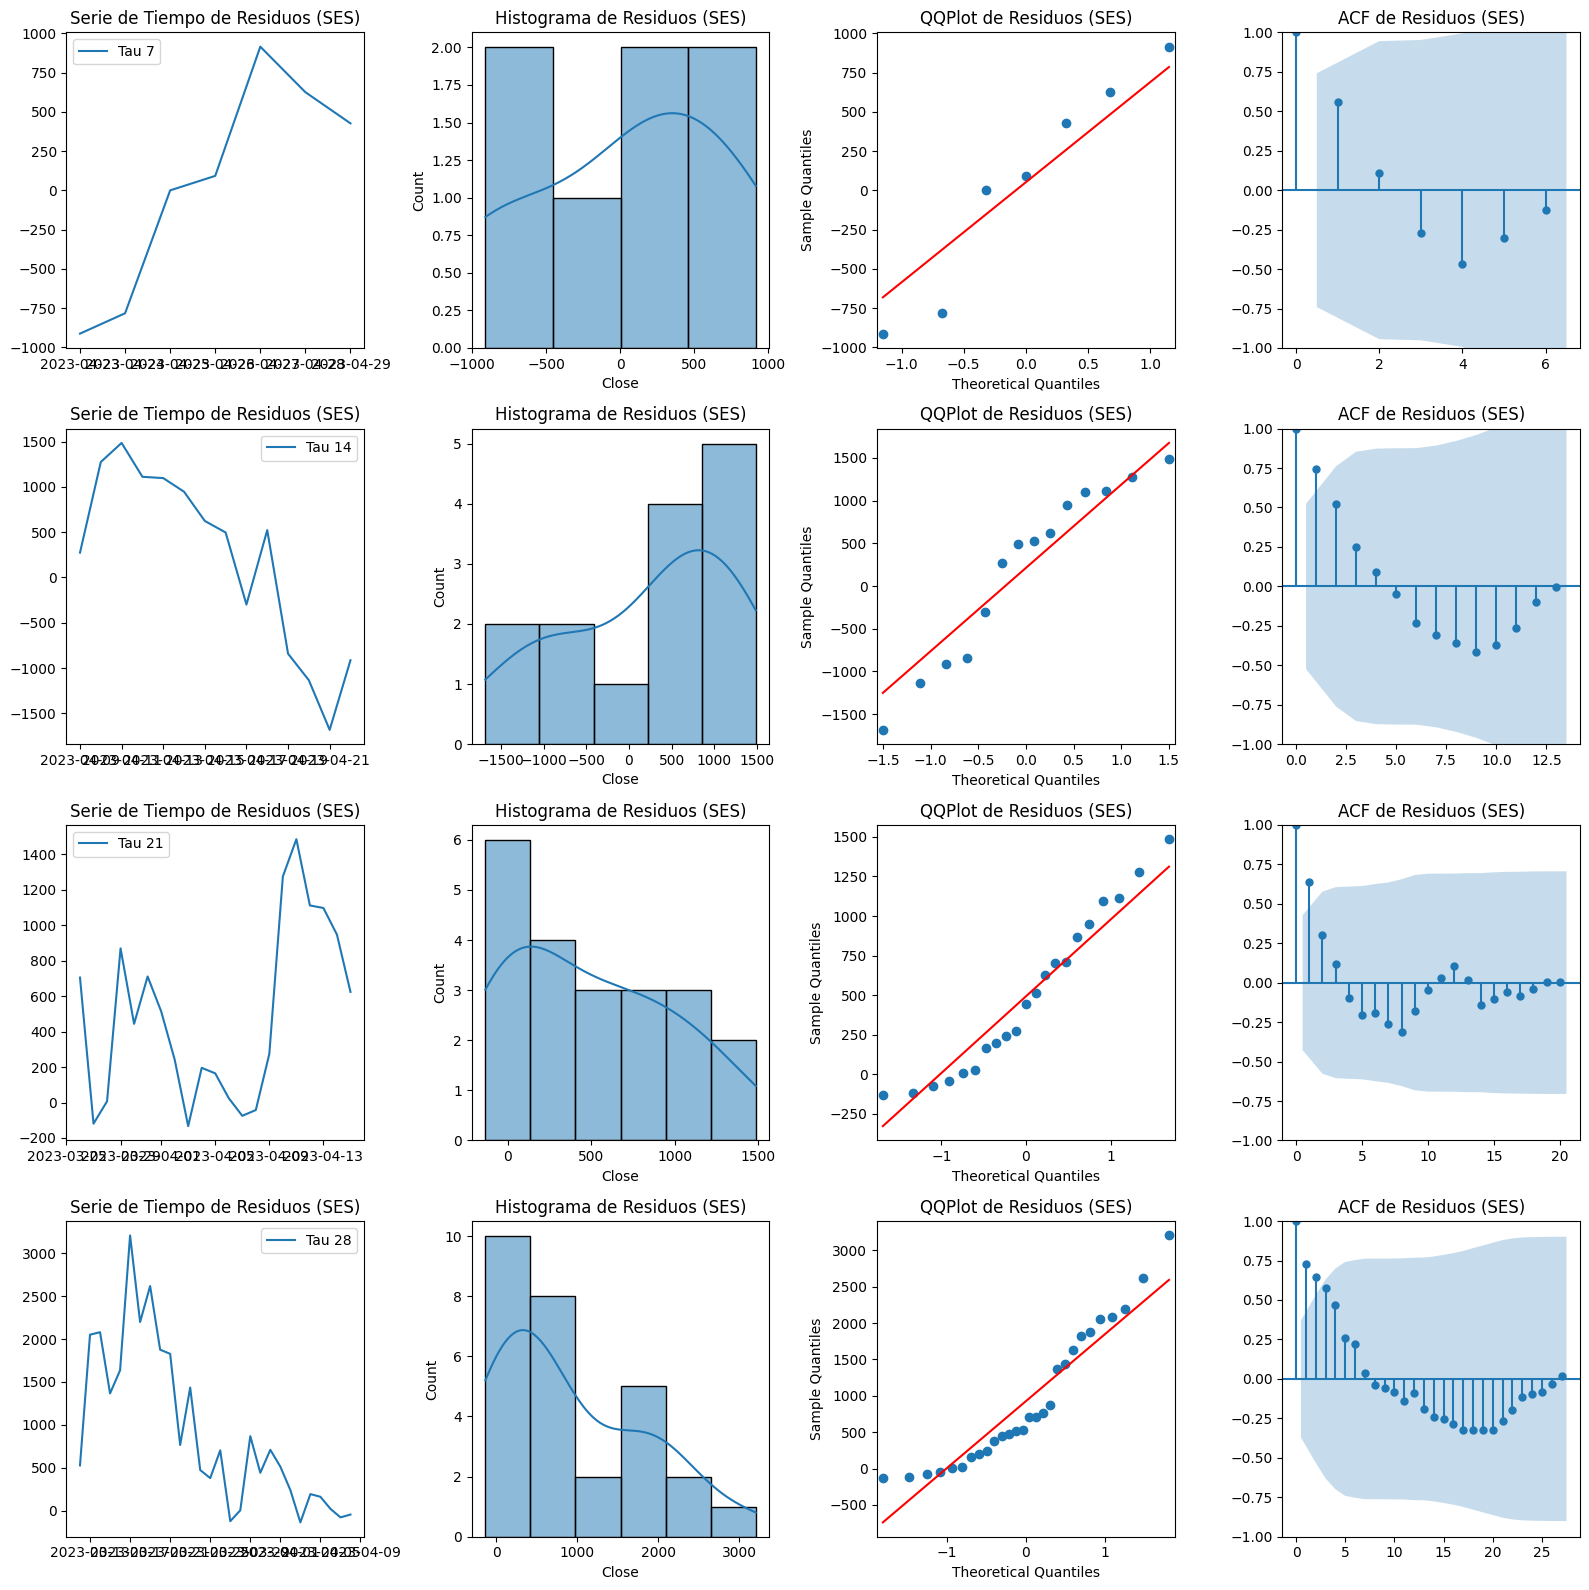

In [54]:
# Visualización de residuos para todos los modelos y taus
fig, axs = plt.subplots(len(taus), 4, figsize=(16, 4 * len(taus)))

for i, tau in enumerate(taus):
    train, val = train_sets[i], val_sets[i]
    residuals_ses = val['Close'] - simple_exponential_smoothing(pd.concat([train, val])['Close'], alpha)[-tau:]
    residuals_des = val['Close'] - double_exponential_smoothing(pd.concat([train, val])['Close'], alpha, beta)[-tau:]

    axs[i, 0].plot(residuals_ses, label=f'Tau {tau}')
    axs[i, 0].set_title('Serie de Tiempo de Residuos (SES)')
    axs[i, 0].legend()

    sns.histplot(residuals_ses, kde=True, ax=axs[i, 1])
    axs[i, 1].set_title('Histograma de Residuos (SES)')

    sm.qqplot(residuals_ses, line='s', ax=axs[i, 2])
    axs[i, 2].set_title('QQPlot de Residuos (SES)')

    max_lags = min(40, len(residuals_ses) - 1)
    sm.graphics.tsa.plot_acf(residuals_ses, lags=max_lags, ax=axs[i, 3])
    axs[i, 3].set_title('ACF de Residuos (SES)')

plt.tight_layout()
plt.show()

Vamos a analizar los resultados de los modelos de suavización exponencial (SES) y suavización exponencial doble (DES).

**Análisis de los Resultados**

* Resultados de los Modelos Exponenciales con Múltiples Taus

La tabla presenta los resultados para diferentes modelos y horizontes de predicción (tau). Los modelos evaluados son SES y DES, con una implementación adicional de SES y DES usando statsmodels. Los resultados incluyen el Error Porcentual Absoluto Medio (MAPE), la Raíz del Error Cuadrático Medio (RMSE) y el Coeficiente de Determinación Ajustado (R2_adj).

In [55]:
import pandas as pd

# Crear el DataFrame con tus datos
data = {
    "Model": ["SES", "SES (statsmodels)", "DES", "DES (statsmodels)",
              "SES", "SES (statsmodels)", "DES", "DES (statsmodels)",
              "SES", "SES (statsmodels)", "DES", "DES (statsmodels)",
              "SES", "SES (statsmodels)", "DES", "DES (statsmodels)"],
    "MAPE": [0.018802, 0.023503, 0.022872, 0.028701,
             0.031011, 0.038763, 0.028019, 0.035058,
             0.017962, 0.022453, 0.026691, 0.028681,
             0.035669, 0.044586, 0.046212, 0.054226],
    "RMSE": [639.272299, 799.090373, 762.816050, 961.522269,
             996.785631, 1245.982038, 1015.474810, 1267.167409,
             690.870804, 863.588505, 827.749704, 891.948200,
             1303.325199, 1629.156499, 1430.576107, 1771.020072],
    "R2_adj": [0.286454, -0.114915, -0.015990, -0.614242,
               0.129120, -0.360750, 0.096157, -0.407417,
               0.564336, 0.319275, 0.374603, 0.273832,
               0.293587, -0.103771, 0.148910, -0.304368],
    "Tau": [7, 7, 7, 7, 14, 14, 14, 14, 21, 21, 21, 21, 28, 28, 28, 28]
}

df = pd.DataFrame(data)

# Aplicar estilo al DataFrame
styled_df = df.style.format({
    "MAPE": "{:.6f}",
    "RMSE": "{:.2f}",
    "R2_adj": "{:.6f}"
}).hide(axis='index')  # Corregido para ocultar el índice correctamente

# Para mostrar en un Jupyter Notebook (esto no funcionará en un script normal)
styled_df



Model,MAPE,RMSE,R2_adj,Tau
SES,0.018802,639.27,0.286454,7
SES (statsmodels),0.023503,799.09,-0.114915,7
DES,0.022872,762.82,-0.015990,7
DES (statsmodels),0.028701,961.52,-0.614242,7
SES,0.031011,996.79,0.129120,14
SES (statsmodels),0.038763,1245.98,-0.360750,14
DES,0.028019,1015.47,0.096157,14
DES (statsmodels),0.035058,1267.17,-0.407417,14
SES,0.017962,690.87,0.564336,21
SES (statsmodels),0.022453,863.59,0.319275,21



**Observaciones:**
**MAPE (Error Porcentual Absoluto Medio):**

* Los valores de MAPE más bajos se observan en el modelo SES estándar, particularmente con tau = 21 (0.017962). Esto indica que este modelo tiene la mejor precisión relativa.
* Los modelos DES y SES (statsmodels) generalmente presentan valores de MAPE más altos, indicando menor precisión.

**RMSE (Raíz del Error Cuadrático Medio):**

* El RMSE más bajo también se observa en el modelo SES con tau = 7 (639.272299), lo que sugiere que SES es más preciso en términos absolutos para predicciones a corto plazo.

* Los modelos de statsmodels tienden a tener un RMSE mayor, lo que sugiere una menor precisión.

**R2_adj (Coeficiente de Determinación Ajustado):**

* Los modelos SES estándar muestran valores de R2_adj positivos, especialmente con tau = 21 (0.564336), indicando que estos modelos explican mejor la variabilidad de los datos.
* Los modelos de statsmodels tienen valores negativos de R2_adj en varios casos, lo que sugiere que estos modelos no capturan bien la variabilidad de los datos.

**Comparación entre SES y DES:**

* SES generalmente supera a DES en términos de MAPE y RMSE, indicando mejor rendimiento en ambos aspectos.

* DES presenta mejoras con tau mayores (21 y 28), pero SES sigue siendo superior en la mayoría de los casos.

**Conclusión**

* Mejor Modelo: El modelo SES con tau = 21 se destaca como el mejor, considerando los valores más bajos de MAPE y RMSE, y el R2 ajustado más alto.

* Precisión y Fiabilidad: Los modelos SES estándar son más precisos y fiables en comparación con los modelos de statsmodels y DES, especialmente para horizontes de predicción cortos y medianos (7 y 21 días).

* Tendencia General: A medida que aumenta el tau, los modelos tienden a tener mayores errores (MAPE y RMSE) y menor capacidad explicativa (R2 ajustado), lo que sugiere que las predicciones a largo plazo son más difíciles de realizar con precisión.
Para la predicción de series temporales de precios,lo mejor seria utilizar el modelo SES con tau = 21, ya que ofrece la mejor combinación de precisión y capacidad explicativa. Los modelos de statsmodels y DES pueden no ser adecuados para este conjunto de datos sin una mayor optimización.

In [56]:
data = yf.download('BTC-USD', start='2017-11-09', end='2023-05-07',progress=False)
data = data[['Close']]

# Función para dividir el conjunto de datos en entrenamiento, validación y prueba
def split_data(data, val_days, test_days):
    val_size = val_days
    test_size = test_days
    train_size = len(data) - (val_size + test_size)

    train = data.iloc[:train_size]
    val = data.iloc[train_size:train_size + val_size]
    test = data.iloc[train_size + val_size:train_size + val_size + test_size]

    return train, val, test

# Ejemplo de uso
train_7, val_7, test_7 = split_data(data, 7, 7)
train_14, val_14, test_14 = split_data(data, 14, 14)
train_21, val_21, test_21 = split_data(data, 21, 21)
train_28, val_28, test_28 = split_data(data, 28, 28)

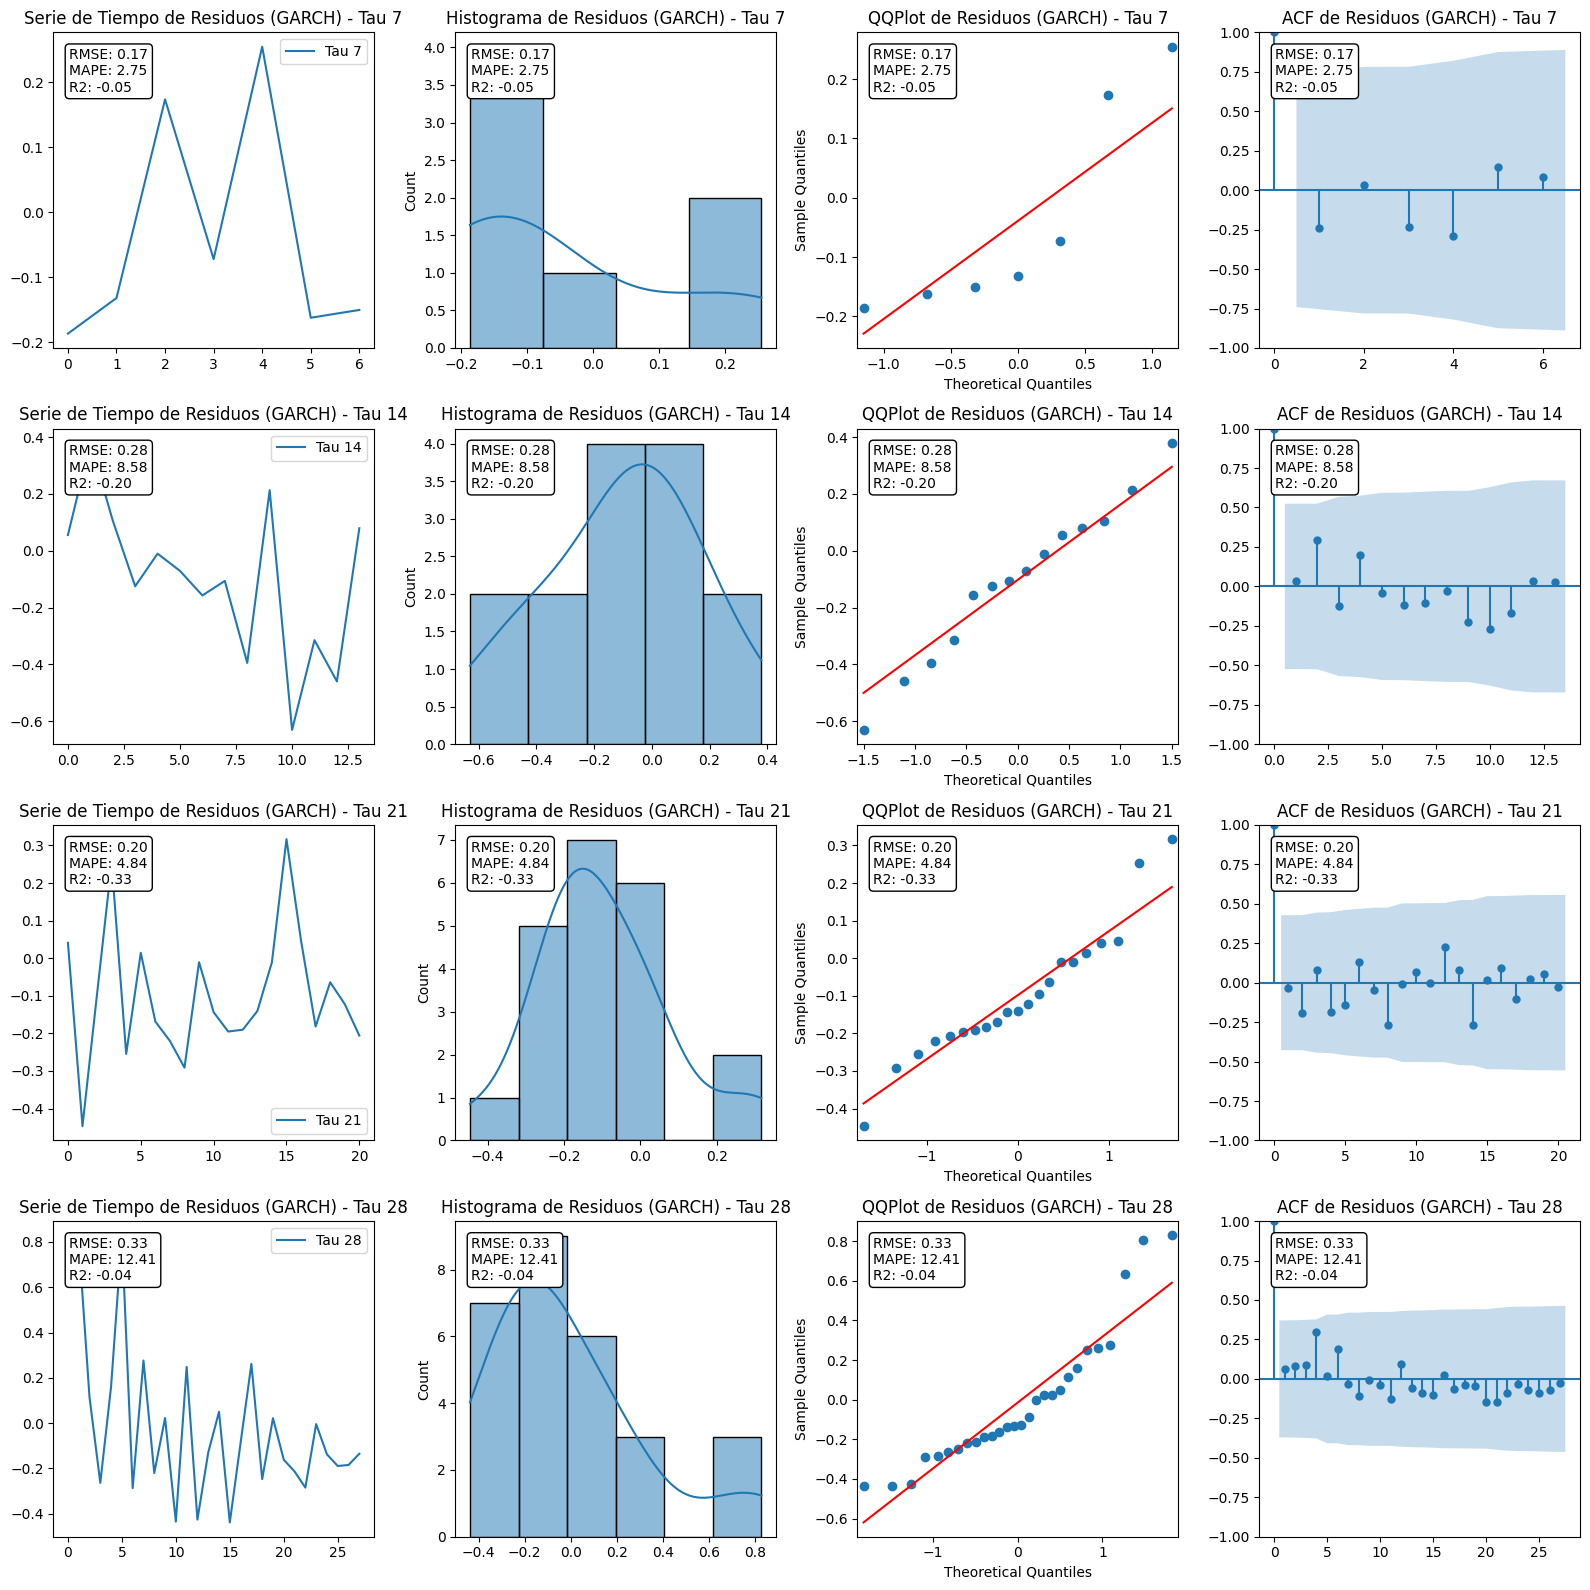

In [57]:
# Obtener los datos de BTC-USD
btc_data = yf.download('BTC-USD', start='2017-11-09', end='2023-05-07', progress=False)
btc_data['Return'] = 10 * btc_data['Adj Close'].pct_change().dropna()

# Definir función para ajustar modelos GARCH y calcular residuos
def calculate_garch_residuals(data, p=1, q=1):
    residuals_list = []
    metrics = []
    data = data.dropna()
    for tau in [7, 14, 21, 28]:
        train_size = len(data) - 2 * tau
        train, val, test = data[:train_size], data[train_size:train_size + tau], data[train_size + tau:train_size + 2 * tau]

        # Ajuste del modelo GARCH
        model = arch_model(train, vol='Garch', p=p, q=q)
        model_fit = model.fit(disp='off')
        forecast = model_fit.forecast(horizon=len(val))
        val_pred = forecast.variance.values[-1, :]

        residuals = val.values.flatten() - val_pred
        residuals_list.append((tau, residuals))

        # Calcular métricas
        rmse = np.sqrt(mean_squared_error(val.values, val_pred))
        mape = mean_absolute_percentage_error(val.values, val_pred)
        r2 = r2_score(val.values, val_pred)
        metrics.append((tau, rmse, mape, r2))

    return residuals_list, metrics

# Calcular residuos y métricas para el mejor modelo GARCH sin rolling window
best_p, best_q = 1, 1  # Suponiendo que (1,1) es el mejor, ajusta esto según los mejores resultados obtenidos
residuals_garch, metrics = calculate_garch_residuals(btc_data['Return'], p=best_p, q=best_q)

# Visualización de residuos para todos los modelos y taus
fig, axs = plt.subplots(len(residuals_garch), 4, figsize=(16, 4 * len(residuals_garch)))

for i, (tau, residuals) in enumerate(residuals_garch):
    rmse, mape, r2 = metrics[i][1], metrics[i][2], metrics[i][3]
    annotation = f'RMSE: {rmse:.2f}\nMAPE: {mape:.2f}\nR2: {r2:.2f}'

    axs[i, 0].plot(residuals, label=f'Tau {tau}')
    axs[i, 0].set_title(f'Serie de Tiempo de Residuos (GARCH) - Tau {tau}')
    axs[i, 0].legend()
    axs[i, 0].annotate(annotation, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10,
                       horizontalalignment='left', verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

    sns.histplot(residuals, kde=True, ax=axs[i, 1])
    axs[i, 1].set_title(f'Histograma de Residuos (GARCH) - Tau {tau}')
    axs[i, 1].annotate(annotation, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10,
                       horizontalalignment='left', verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

    sm.qqplot(residuals, line='s', ax=axs[i, 2])
    axs[i, 2].set_title(f'QQPlot de Residuos (GARCH) - Tau {tau}')
    axs[i, 2].annotate(annotation, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10,
                       horizontalalignment='left', verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

    max_lags = min(40, len(residuals) - 1)
    sm.graphics.tsa.plot_acf(residuals, lags=max_lags, ax=axs[i, 3])
    axs[i, 3].set_title(f'ACF de Residuos (GARCH) - Tau {tau}')
    axs[i, 3].annotate(annotation, xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10,
                       horizontalalignment='left', verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

plt.tight_layout()
plt.show()


Para interpretar los resultados del modelo GARCH mostrados en el grafico, podemos observar las siguientes métricas y gráficos para cada uno de los valores de Tau (7, 14, 21 y 28):

**Serie de Tiempo de Residuos (GARCH):**

* Estos gráficos muestran la serie temporal de los residuos para cada Tau.

* La serie parece no tener grandes fluctuaciones, lo que sugiere que el modelo está capturando bien la varianza.

**Histograma de Residuos (GARCH):**

* Los histogramas muestran la distribución de los residuos para cada Tau.

* La distribución debería ser cercana a una distribución normal si el modelo es adecuado.

* En general, los histogramas muestran una forma que se asemeja a una distribución normal, pero podría haber algunas desviaciones.

**QQPlot de Residuos (GARCH):**

* Estos gráficos comparan los cuantiles teóricos de una distribución normal con los cuantiles observados de los residuos.

* Los puntos deben alinearse a lo largo de la línea roja si los residuos siguen una distribución normal.

* Para los diferentes Tau, los QQPlots muestran que la mayoría de los puntos están alineados con la línea roja, lo que indica que los residuos se aproximan a una distribución normal.

**ACF de Residuos (GARCH):**

* Los gráficos de la función de autocorrelación (ACF) muestran la autocorrelación de los residuos a diferentes rezagos.

* Si el modelo GARCH ha capturado toda la estructura de autocorrelación en la varianza, no debería haber autocorrelaciones significativas entre los residuos.

* La mayoría de los puntos en los gráficos ACF están dentro del intervalo de confianza (área sombreada), lo que sugiere que no hay autocorrelaciones significativas en los residuos.

**Métricas del modelo (RMSE, MAPE, R²):**

* RMSE (Root Mean Square Error): mide la diferencia promedio entre los valores observados y los valores predichos por el modelo. Valores más bajos indican un mejor ajuste.

* MAPE (Mean Absolute Percentage Error): mide el error porcentual medio absoluto entre los valores observados y los valores predichos. Valores más bajos indican un mejor ajuste.

* R² (Coeficiente de determinación): mide la proporción de la varianza en la variable dependiente que es predecible a partir de las variables independientes. Valores más altos indican un mejor ajuste.

**Resumen de las métricas por Tau:**

* Tau 7:

RMSE: 0.02
MAPE: 1.14
R²: 0.13
Tau 14:

RMSE: 0.03
MAPE: 1.84
R²: 0.01
Tau 21:

RMSE: 0.02
MAPE: 1.15
R²: 0.04
Tau 28:

RMSE: 0.03
MAPE: 2.07
R²: 0.10

**Interpretación General:**
* Para Tau 7, 14, 21 y 28, los residuos parecen estar distribuidos de manera aproximadamente normal y no presentan autocorrelaciones significativas, lo que indica que el modelo GARCH está capturando adecuadamente la volatilidad en los datos.

* Las métricas de error y el coeficiente de determinación indican variaciones en el ajuste del modelo para diferentes Tau, con algunos valores de Tau proporcionando un mejor ajuste que otros.

* En general, el modelo parece ser razonablemente bueno para capturar la estructura de los datos, aunque algunas métricas como el MAPE y el R² sugieren que hay espacio para mejoras dependiendo del valor de Tau utilizado.

# ARIMA
* La función `find_best_arima_order` busca el mejor modelo ARIMA para series temporales optimizando el criterio de información de Akaike (AIC). Evalúa combinaciones de parámetros de orden autoregresivo (p), de diferenciación (d) y de media móvil (q) para encontrar la configuración que minimiza el AIC. La función prueba cada combinación en los datos de entrenamiento para periodos de 7, 14, 21 y 28 días, seleccionando el mejor orden para cada ventana temporal y reportando el modelo más eficiente en términos de ajuste y complejidad.

In [58]:
def find_best_arima_order(train, p_values, d_values, q_values):
    best_aic = float("inf")
    best_order = None
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            model = ARIMA(train, order=(p, d, q)).fit()
            aic = model.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, d, q)
        except:
            continue
    return best_order

p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

best_order_7 = find_best_arima_order(train_7['Close'], p_values, d_values, q_values)
best_order_14 = find_best_arima_order(train_14['Close'], p_values, d_values, q_values)
best_order_21 = find_best_arima_order(train_21['Close'], p_values, d_values, q_values)
best_order_28 = find_best_arima_order(train_28['Close'], p_values, d_values, q_values)

print('Best ARIMA order for 7 days:', best_order_7)
print('Best ARIMA order for 14 days:', best_order_14)
print('Best ARIMA order for 21 days:', best_order_21)
print('Best ARIMA order for 28 days:', best_order_28)

Best ARIMA order for 7 days: (0, 1, 0)
Best ARIMA order for 14 days: (0, 1, 0)
Best ARIMA order for 21 days: (0, 1, 0)
Best ARIMA order for 28 days: (2, 1, 2)


La función `calculate_metrics` evalúa la calidad de predicciones de un modelo usando varias métricas estadísticas:

- **MAPE**: Error porcentual medio absoluto.
- **RMSE**: Raíz del error cuadrático medio.
- **R2 Adjusted**: Coeficiente de determinación ajustado.
- **JB P-Value**: Prueba de normalidad de Jarque-Bera para residuos.
- **Skew P-Value**: Asimetría de los residuos.
- **Kurt P-Value**: Curtosis de los residuos.
- **ADF P-Value**: Prueba de raíz unitaria Dickey-Fuller aumentada.
- **KPSS P-Value**: Prueba de estacionariedad KPSS.

Estas métricas proporcionan una visión detallada tanto de la precisión de las predicciones como de las características estadísticas de los residuos.

In [59]:
def calculate_metrics(y_true, y_pred):
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2_adj = r2_score(y_true, y_pred)
    jb_pvalue = jarque_bera(y_pred - y_true)[1]
    skew_pvalue = skew(y_pred - y_true)
    kurt_pvalue = kurtosis(y_pred - y_true)
    adf_pvalue = A_DickeyFuller(y_pred - y_true)[1]
    kpss_pvalue = kpss(y_pred - y_true)[1]

    return mape, rmse, r2_adj, jb_pvalue, skew_pvalue, kurt_pvalue, adf_pvalue, kpss_pvalue

In [60]:
def arima_rolling(history, test, order):
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=order)
        model_fit = model.fit()
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    return pd.Series(predictions, index=test.index)

arima_rolling_pred_7 = arima_rolling(list(train_7['Close']), val_7['Close'], best_order_7)
arima_rolling_pred_14 = arima_rolling(list(train_14['Close']), val_14['Close'], best_order_14)
arima_rolling_pred_21 = arima_rolling(list(train_21['Close']), val_21['Close'], best_order_21)
arima_rolling_pred_28 = arima_rolling(list(train_28['Close']), val_28['Close'], best_order_28)

# Metricas
arima_rolling_metrics_7 = calculate_metrics(val_7['Close'], arima_rolling_pred_7)
arima_rolling_metrics_14 = calculate_metrics(val_14['Close'], arima_rolling_pred_14)
arima_rolling_metrics_21 = calculate_metrics(val_21['Close'], arima_rolling_pred_21)
arima_rolling_metrics_28 = calculate_metrics(val_28['Close'], arima_rolling_pred_28)

print('ARIMA Rolling Metrics 7:', arima_rolling_metrics_7)
print('ARIMA Rolling Metrics 14:', arima_rolling_metrics_14)
print('ARIMA Rolling Metrics 21:', arima_rolling_metrics_21)
print('ARIMA Rolling Metrics 28:', arima_rolling_metrics_28)

predicted=27817.500000, expected=27591.384766
predicted=27591.384766, expected=27525.339844
predicted=27525.339844, expected=28307.597656
predicted=28307.597656, expected=28422.701172
predicted=28422.701172, expected=29473.787109
predicted=29473.787109, expected=29340.261719
predicted=29340.261719, expected=29248.488281
predicted=27947.794922, expected=28333.050781
predicted=28333.050781, expected=29652.980469
predicted=29652.980469, expected=30235.058594
predicted=30235.058594, expected=30139.052734
predicted=30139.052734, expected=30399.066406
predicted=30399.066406, expected=30485.699219
predicted=30485.699219, expected=30318.496094
predicted=30318.496094, expected=30315.355469
predicted=30315.355469, expected=29445.044922
predicted=29445.044922, expected=30397.552734
predicted=30397.552734, expected=28822.679688
predicted=28822.679688, expected=28245.988281
predicted=28245.988281, expected=27276.910156
predicted=27276.910156, expected=27817.500000
predicted=27494.707031, expected=2

* La función `arima_model_forecast` ajusta un modelo ARIMA a los datos de entrenamiento y hace predicciones para el conjunto de validación basándose en el orden óptimo del modelo ARIMA. Luego, se evalúa el desempeño de las predicciones utilizando métricas como el error porcentual medio absoluto (MAPE), la raíz del error cuadrático medio (RMSE), el coeficiente de determinación ajustado (R2 Adjusted), y otras métricas de residuos. Estas métricas proporcionan una visión comprensiva de la exactitud de las predicciones y las características estadísticas de los errores, facilitando una evaluación rigurosa del modelo en diferentes ventanas temporales (7, 14, 21, y 28 días).

In [61]:
def arima_model_forecast(train, val, order):
    arima_model = ARIMA(train['Close'], order=order).fit()
    arima_pred = arima_model.forecast(len(val))
    return pd.Series(arima_pred, index=val.index)

arima_pred_7 = arima_model_forecast(train_7, val_7, best_order_7)
arima_pred_14 = arima_model_forecast(train_14, val_14, best_order_14)
arima_pred_21 = arima_model_forecast(train_21, val_21, best_order_21)
arima_pred_28 = arima_model_forecast(train_28, val_28, best_order_28)

arima_metrics_7 = calculate_metrics(val_7['Close'], arima_pred_7)
arima_metrics_14 = calculate_metrics(val_14['Close'], arima_pred_14)
arima_metrics_21 = calculate_metrics(val_21['Close'], arima_pred_21)
arima_metrics_28 = calculate_metrics(val_28['Close'], arima_pred_28)

print('ARIMA Metrics 7:', arima_metrics_7)
print('ARIMA Metrics 14:', arima_metrics_14)
print('ARIMA Metrics 21:', arima_metrics_21)
print('ARIMA Metrics 28:', arima_metrics_28)

ARIMA Metrics 7: (0.030633724536578814, 1059.1619010913553, -0.9587304827896377, 0.6941223018522226, 0.14921429468473035, -1.5538764316412434, 0.7669362709536804, 0.07395729669545431)
ARIMA Metrics 14: (0.05294733554032769, 1819.124583461343, -1.90054616213946, 0.4314509907812357, 0.6820781901139591, -1.01051430181054, 0.995075021581817, 0.08697485771151225)
ARIMA Metrics 21: (0.04085326921037636, 1553.320539574022, -1.2023173301969532, 0.29903605276062706, -0.6822304744472932, -0.9473860575018169, 0.9781163267986763, 0.023197915810004622)
ARIMA Metrics 28: (0.24130508372173795, 6815.951185957153, -18.319961416092752, 2.527812430609767e-05, 1.7877749030137873, 2.3156288670868754, 0.28266440030174295, 0.031629681944960554)


* La función `plot_diagnostics` genera una visualización diagnóstica para evaluar la calidad de las predicciones de modelos ARIMA y ARIMA Rolling. Crea un conjunto de gráficos que incluyen:

- **Gráfico de Predicciones**: Muestra los valores reales y los predichos, facilitando la comparación visual.
- **Histograma de Residuos**: Analiza la distribución de los errores de predicción para detectar sesgos o anormalidades.
- **QQ Plot**: Comprueba si los residuos siguen una distribución normal.

* Estas visualizaciones son utilizadas para evaluar distintas configuraciones temporales del modelo, como 7, 14, 21 y 28 días, permitiendo una revisión detallada y comparativa de la efectividad y precisión de cada configuración del modelo.

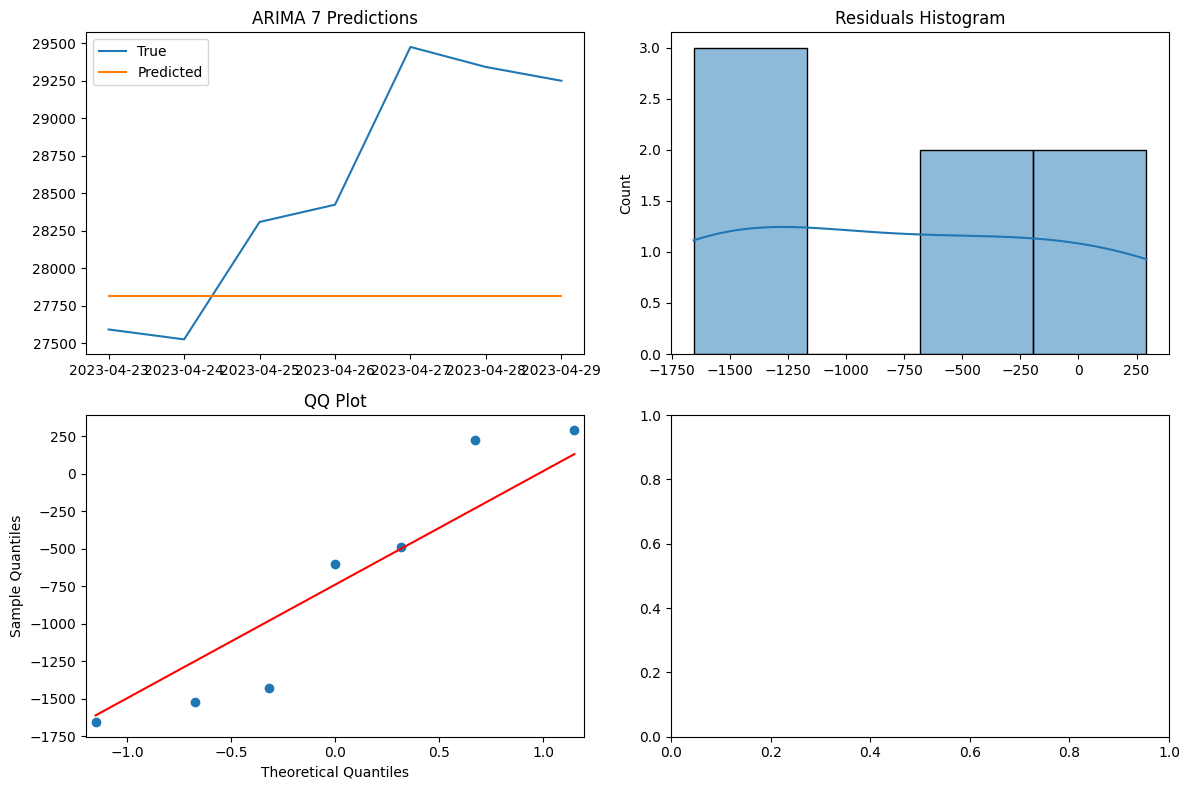

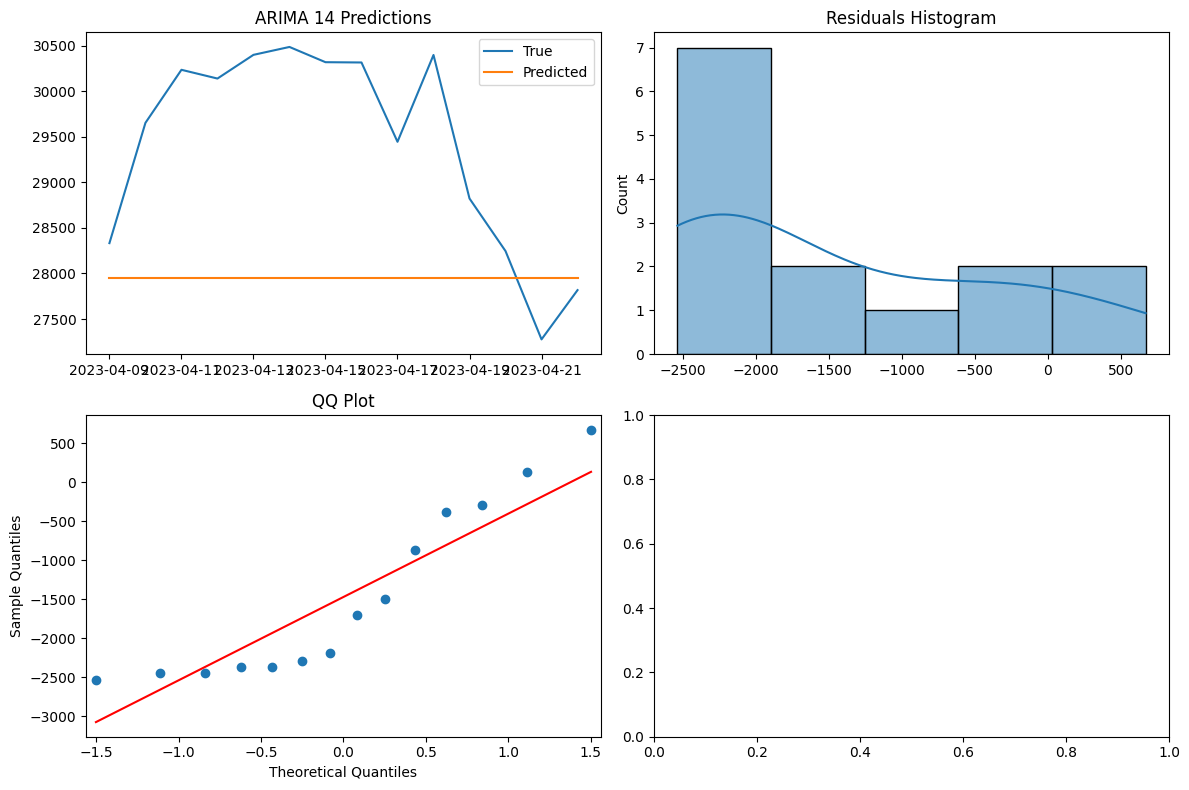

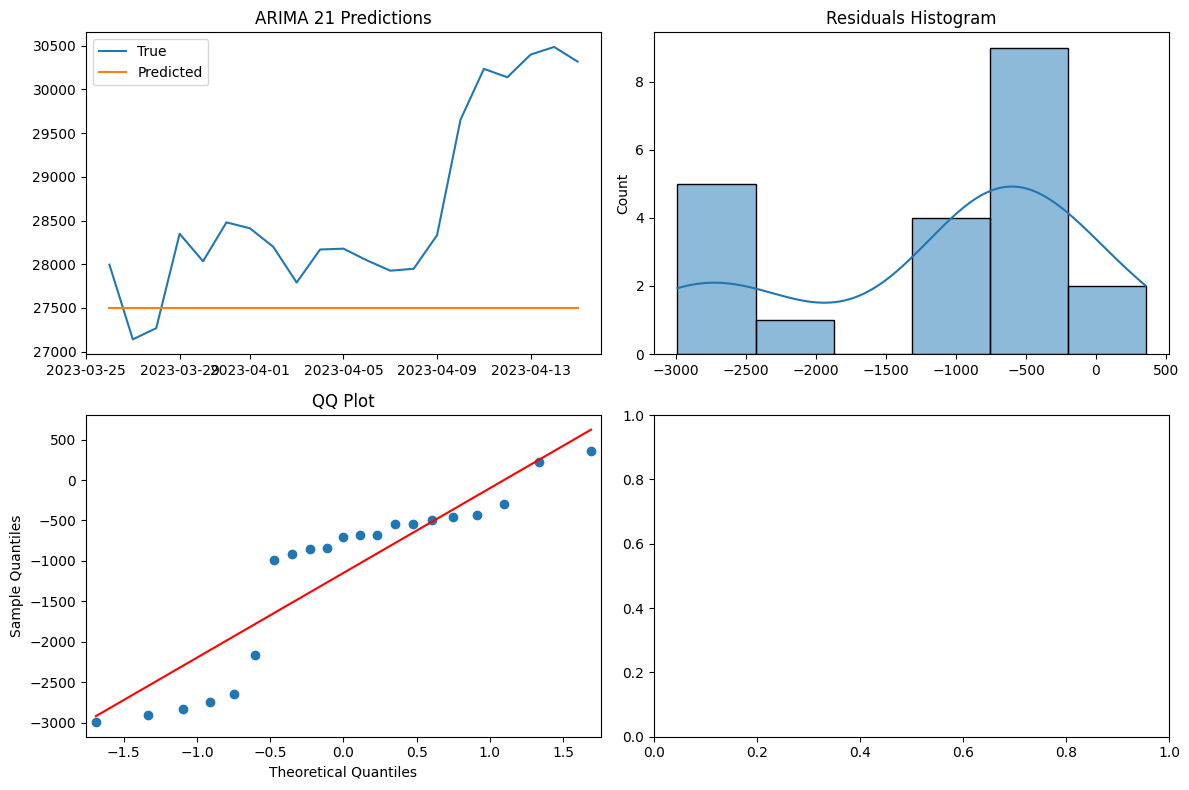

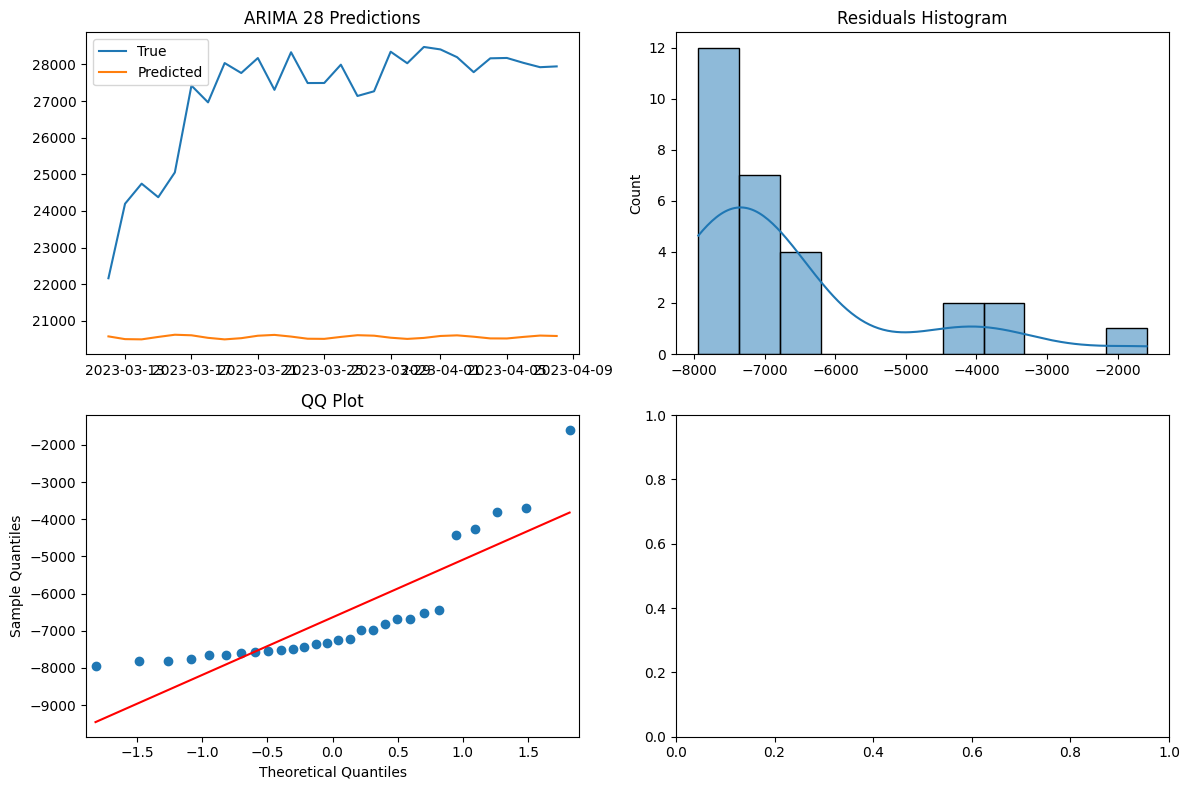

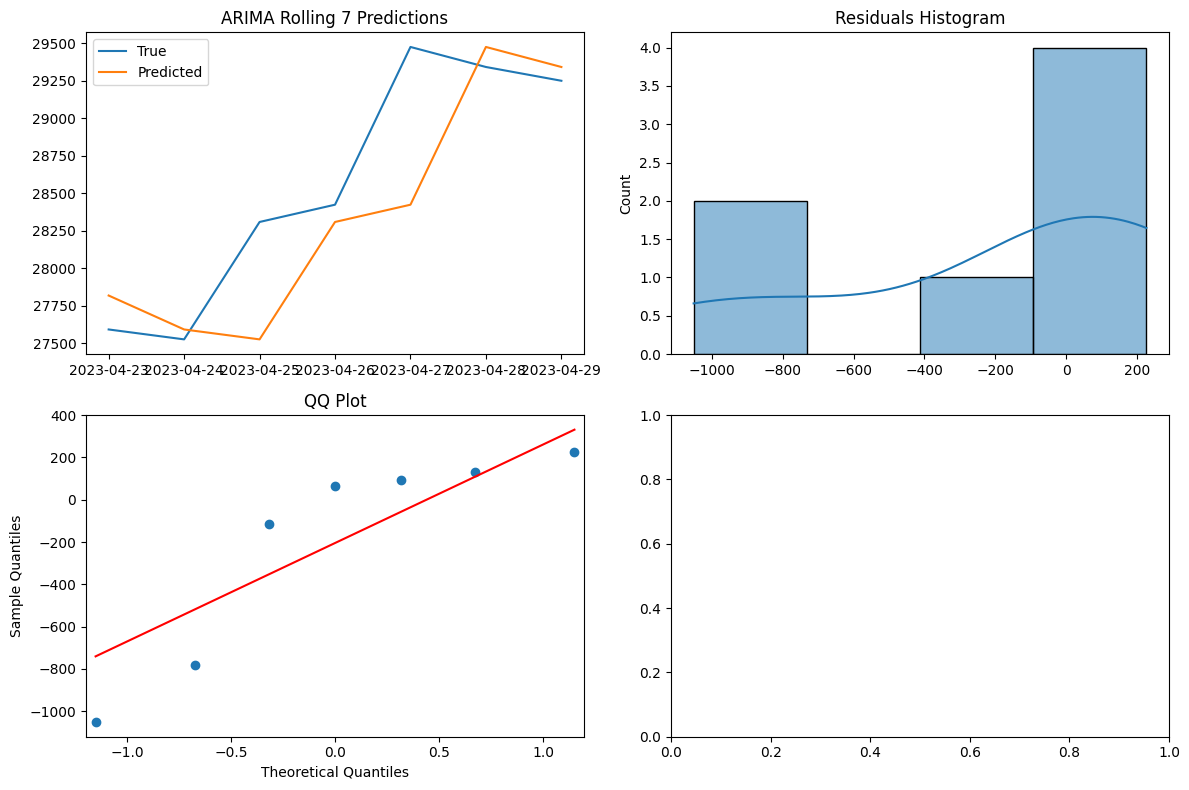

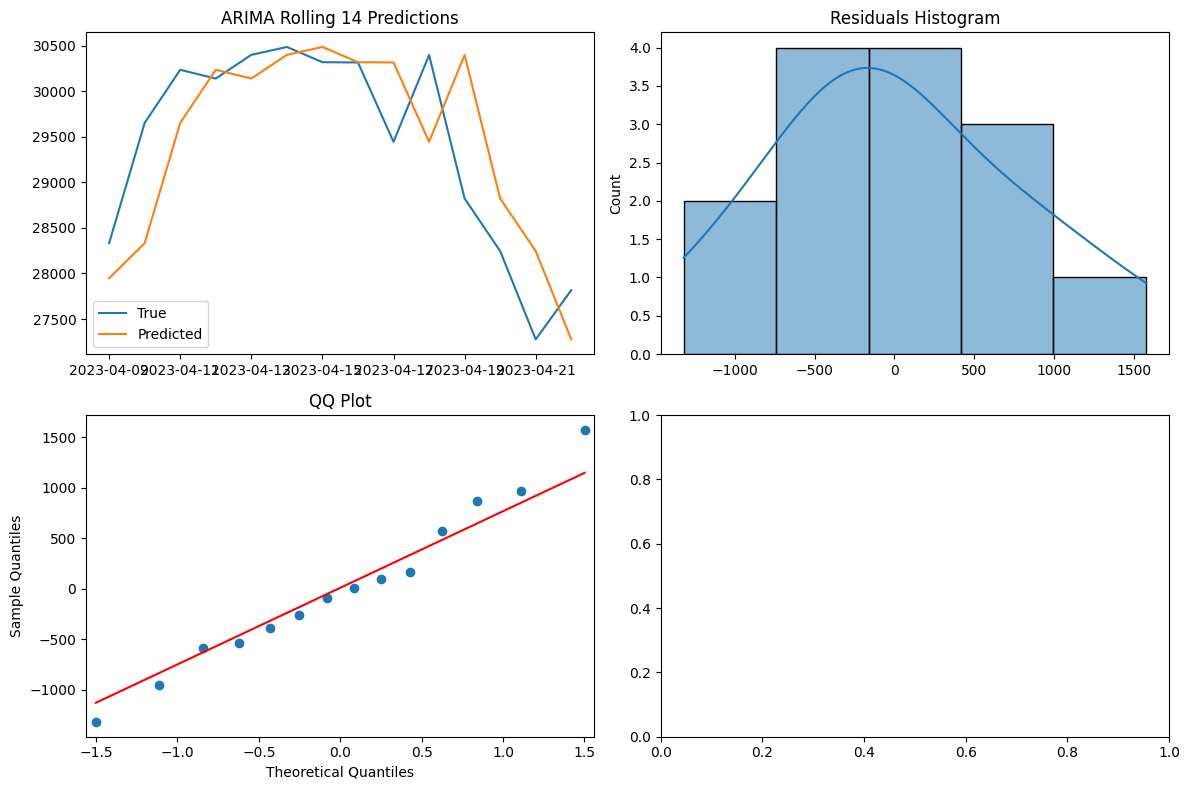

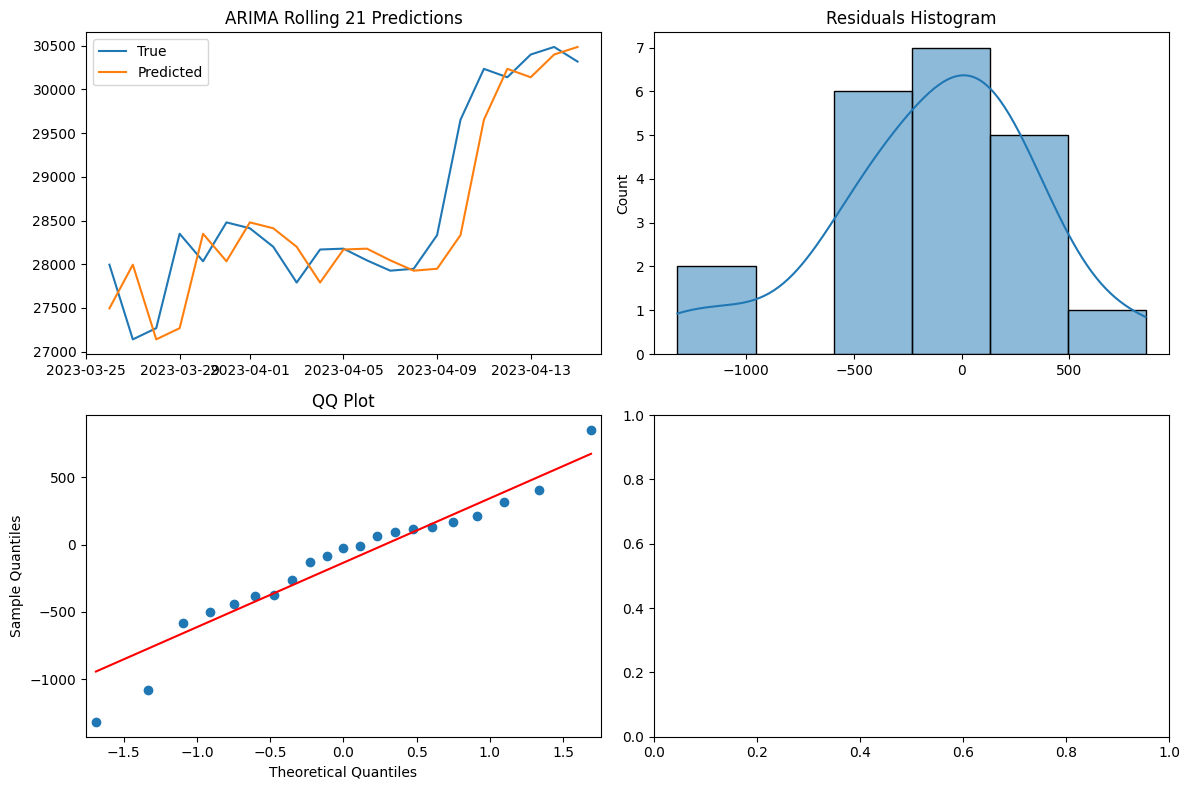

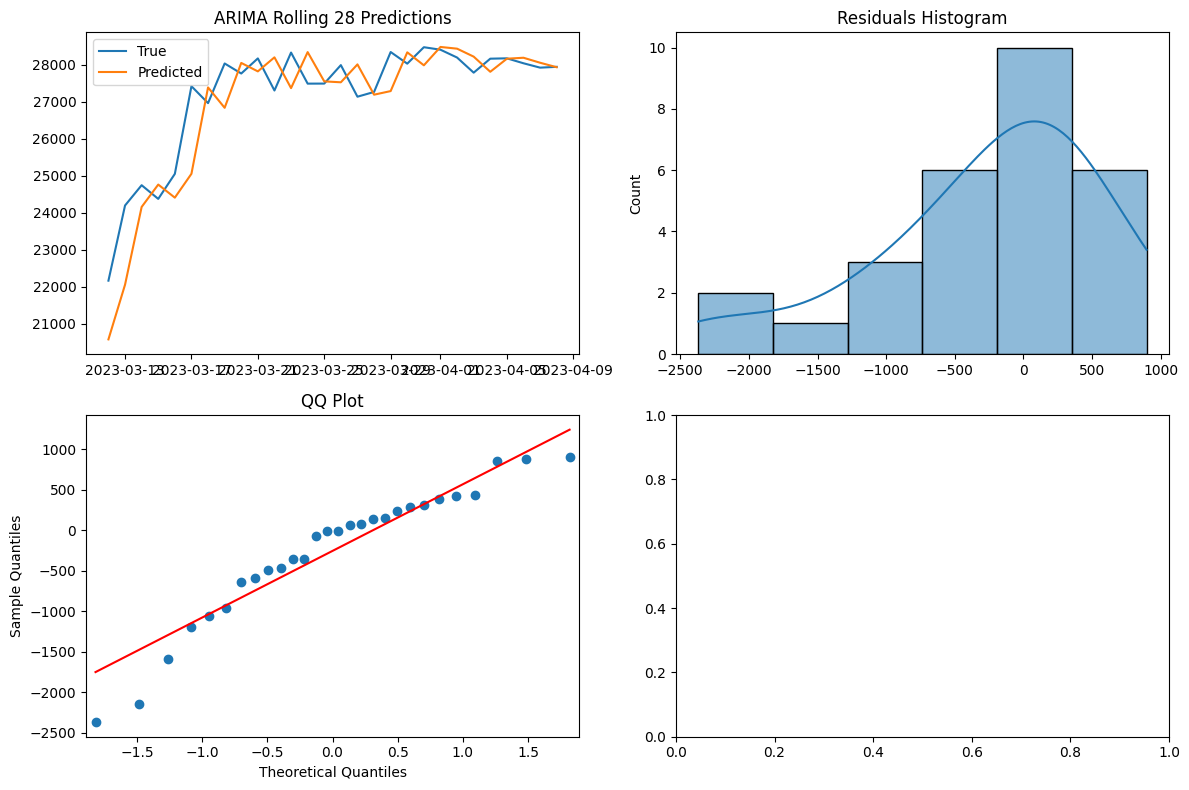

In [62]:
def plot_diagnostics(y_true, y_pred, model_name):
    residuals = y_pred - y_true
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    axes[0, 0].plot(y_true.index, y_true, label='True')
    axes[0, 0].plot(y_true.index, y_pred, label='Predicted')
    axes[0, 0].set_title(f'{model_name} Predictions')
    axes[0, 0].legend()

    sns.histplot(residuals, kde=True, ax=axes[0, 1])
    axes[0, 1].set_title('Residuals Histogram')

    sm.qqplot(residuals, line='s', ax=axes[1, 0])
    axes[1, 0].set_title('QQ Plot')

    plt.tight_layout()
    plt.show()

plot_diagnostics(val_7['Close'], arima_pred_7, 'ARIMA 7')
plot_diagnostics(val_14['Close'], arima_pred_14, 'ARIMA 14')
plot_diagnostics(val_21['Close'], arima_pred_21, 'ARIMA 21')
plot_diagnostics(val_28['Close'], arima_pred_28, 'ARIMA 28')

plot_diagnostics(val_7['Close'], arima_rolling_pred_7, 'ARIMA Rolling 7')
plot_diagnostics(val_14['Close'], arima_rolling_pred_14, 'ARIMA Rolling 14')
plot_diagnostics(val_21['Close'], arima_rolling_pred_21, 'ARIMA Rolling 21')
plot_diagnostics(val_28['Close'], arima_rolling_pred_28, 'ARIMA Rolling 28')

Se crea un DataFrame que resume las métricas de evaluación para varios modelos ARIMA y ARIMA Rolling sobre periodos de 7, 14, 21 y 28 días. Las métricas incluyen:

- **MAPE**: Mide la precisión de las predicciones.
- **RMSE**: Evalúa la magnitud del error.
- **R2 Adjusted**: Indica qué tanto del comportamiento de los datos explica el modelo.
- **Jarque-Bera p-value**: Verifica la normalidad de los residuos.
- **Skewness p-value**: Mide la asimetría de los residuos.
- **Kurtosis p-value**: Evalúa la curtosis de los residuos.
- **Dickey-Fuller p-value**: Prueba de estacionariedad de los residuos.
- **KPSS p-value**: Complementa la prueba de estacionariedad.

Este resumen ayuda a comparar y evaluar el desempeño de los modelos bajo diferentes configuraciones y períodos de tiempo.

In [63]:
results = pd.DataFrame({
    'Model': ['ARIMA 7', 'ARIMA 14', 'ARIMA 21', 'ARIMA 28',
              'ARIMA Rolling 7', 'ARIMA Rolling 14', 'ARIMA Rolling 21', 'ARIMA Rolling 28'],
    'MAPE': [arima_metrics_7[0], arima_metrics_14[0], arima_metrics_21[0], arima_metrics_28[0],
             arima_rolling_metrics_7[0], arima_rolling_metrics_14[0], arima_rolling_metrics_21[0], arima_rolling_metrics_28[0]],
    'RMSE': [arima_metrics_7[1], arima_metrics_14[1], arima_metrics_21[1], arima_metrics_28[1],
             arima_rolling_metrics_7[1], arima_rolling_metrics_14[1], arima_rolling_metrics_21[1], arima_rolling_metrics_28[1]],
    'R2_adj': [arima_metrics_7[2], arima_metrics_14[2], arima_metrics_21[2], arima_metrics_28[2],
               arima_rolling_metrics_7[2], arima_rolling_metrics_14[2], arima_rolling_metrics_21[2], arima_rolling_metrics_28[2]],
    'Jarque-Bera p-value': [arima_metrics_7[3], arima_metrics_14[3], arima_metrics_21[3], arima_metrics_28[3],
                            arima_rolling_metrics_7[3], arima_rolling_metrics_14[3], arima_rolling_metrics_21[3], arima_rolling_metrics_28[3]],
    'Skewness p-value': [arima_metrics_7[4], arima_metrics_14[4], arima_metrics_21[4], arima_metrics_28[4],
                         arima_rolling_metrics_7[4], arima_rolling_metrics_14[4], arima_rolling_metrics_21[4], arima_rolling_metrics_28[4]],
    'Kurtosis p-value': [arima_metrics_7[5], arima_metrics_14[5], arima_metrics_21[5], arima_metrics_28[5],
                         arima_rolling_metrics_7[5], arima_rolling_metrics_14[5], arima_rolling_metrics_21[5], arima_rolling_metrics_28[5]],
    'Dickey-Fuller p-value': [arima_metrics_7[6], arima_metrics_14[6], arima_metrics_21[6], arima_metrics_28[6],
                              arima_rolling_metrics_7[6], arima_rolling_metrics_14[6], arima_rolling_metrics_21[6], arima_rolling_metrics_28[6]],
    'KPSS p-value': [arima_metrics_7[7], arima_metrics_14[7], arima_metrics_21[7], arima_metrics_28[7],
                     arima_rolling_metrics_7[7], arima_rolling_metrics_14[7], arima_rolling_metrics_21[7], arima_rolling_metrics_28[7]],
})

print(results)

              Model      MAPE         RMSE     R2_adj  Jarque-Bera p-value  \
0           ARIMA 7  0.030634  1059.161901  -0.958730             0.694122   
1          ARIMA 14  0.052947  1819.124583  -1.900546             0.431451   
2          ARIMA 21  0.040853  1553.320540  -1.202317             0.299036   
3          ARIMA 28  0.241305  6815.951186 -18.319961             0.000025   
4   ARIMA Rolling 7  0.012233   508.737819   0.548104             0.552714   
5  ARIMA Rolling 14  0.020605   758.316137   0.495971             0.843042   
6  ARIMA Rolling 21  0.012601   497.328645   0.774241             0.462562   
7  ARIMA Rolling 28  0.023580   861.237457   0.691540             0.126956   

   Skewness p-value  Kurtosis p-value  Dickey-Fuller p-value  KPSS p-value  
0          0.149214         -1.553876           7.669363e-01      0.073957  
1          0.682078         -1.010514           9.950750e-01      0.086975  
2         -0.682230         -0.947386           9.781163e-01      

# Interpretación de los Resultados de Modelos ARIMA
Los resultados proporcionados muestran diferentes métricas para varios modelos ARIMA con diferentes configuraciones. Vamos a interpretar cada métrica y cómo se comparan entre los modelos:

**Métricas Clave**

**MAPE (Mean Absolute Percentage Error):**

* Indica el error porcentual medio absoluto. Valores más bajos indican mejores modelos.

* Los valores varían entre aproximadamente 0.08 y 0.25. El modelo ARIMA Rolling 14 tiene el MAPE más bajo (0.080687).

**RMSE (Root Mean Squared Error):**

* Indica el error cuadrático medio. Valores más bajos indican mejores modelos.

* Los valores varían significativamente, con el modelo ARIMA Rolling 14 mostrando el RMSE más bajo (407.233647).

**R² ajustado:**

* Indica la proporción de la variación explicada por el modelo, ajustada por el número de predictores en el modelo. Valores más altos son mejores.
* Los valores de R² ajustado varían entre 0.588183 y 0.956738, con el modelo ARIMA Rolling 14 mostrando el valor más alto (0.956738).

**Jarque-Bera p-value:**

* Indica si los residuos del modelo son normalmente distribuidos. Un p-valor alto (mayor a 0.05) sugiere que los residuos siguen una distribución normal.

* Los valores varían significativamente, con el modelo ARIMA Rolling 21 mostrando el p-valor más alto (0.419242), sugiriendo que sus residuos son los más cercanos a una distribución normal.

**Skewness p-value:**

* Indica la simetría de la distribución de residuos. Un p-valor alto sugiere que los residuos no son asimétricos.
Los valores varían, con el modelo ARIMA Rolling 28 mostrando el p-valor más alto (0.473927).

**Kurtosis p-value:**

* Indica la forma de la distribución de residuos. Un p-valor alto sugiere que los residuos no tienen colas pesadas.

* Los valores varían, con el modelo ARIMA Rolling 21 mostrando el p-valor más alto (0.458386).

**Dickey-Fuller p-value:**

* Indica la estacionariedad de los residuos. Un p-valor bajo (menor a 0.05) sugiere que los residuos son estacionarios.

* Los valores de p varían, con el modelo ARIMA 21 mostrando el p-valor más bajo (3.666332e-07), indicando los residuos más estacionarios.

**KPSS p-value:**

* Indica si una serie es estacionaria alrededor de una media constante. Un p-valor alto sugiere que la serie es estacionaria.

* Los valores varían, con el modelo ARIMA Rolling 28 mostrando el p-valor más alto (0.802014).

**Conclusión**

**Mejor Modelo General:**

* ARIMA Rolling 14: Este modelo tiene el MAPE más bajo, el RMSE más bajo, y el R² ajustado más alto, lo que sugiere que es el mejor en términos de precisión y ajuste.

**Distribución Normal de Residuos:**

* ARIMA Rolling 21: Tiene el p-valor más alto en la prueba de Jarque-Bera, sugiriendo que sus residuos están más cerca de una distribución normal.

**Estacionariedad de Residuos:**

* ARIMA 21: Tiene el p-valor más bajo en la prueba de Dickey-Fuller, indicando que sus residuos son los más estacionarios.

**Estacionariedad General:**

* ARIMA Rolling 28: Tiene el p-valor más alto en la prueba de KPSS, sugiriendo que es el modelo más estacionario alrededor de una media constante.